# Supp Figures C, D and E are in this notebook

In [1]:
suppressPackageStartupMessages({
    library(lme4)
    library(DESeq2)
    library(tidyr)
    library(dplyr)
    library(tibble)
    library(pheatmap)
    library(fgsea)
    library(data.table)
    library(purrr)
    library(ggrepel)
    library(scales)
    library(readxl)
    library(patchwork)
    library(stringr)
    library(hise)
    library(plyr)
    library(vegan)
    library(rstatix)
    library(parallel)
    library(ggpubr)
    library(ggsci)
    library(ggplot2)
})

## DESeq2 Pre-processing (Takes about 10min)

In [3]:
#Load meta data for antigen specific meta data
metadata <- read.csv("/home//jupyter//BRI_Figures_Final_V2/Extended-Figure4/01_Frequency_Comparison/selected_samples_with_acutal_flu_year.csv")

rownames(metadata) <- metadata$pbmc_sample_id
rownames(metadata) <- gsub("-", ".", rownames(metadata))
metadata <- as.data.frame(metadata)

# filter for y1d7 so that we can do pathway analysis comparing year 1 day 7 between BR1 and BR2
meta_data_subset<-metadata%>% filter(cohort.cohortGuid %in% c('BR1', 'BR2'),sample.visitName %in% c('Flu Year 1 Day 7', 'Flu Year 2 Day 7'))

In [4]:
#pull psb files
start_time <- Sys.time()

# Read the column "pbmc_sample_id" from the dataframe "meta_data_subset"
pbmc_sample_ids <- meta_data_subset$pbmc_sample_id

# Directory containing the CSV files
data_dir <- "/home//jupyter//BRI_Figures_Final_V2/Dataset/scRNA/BRI/Aggregated_Count/Aggregated_Raw_Expression_of_Celltypes_by_Sample_AIFI_L3/"

# Function to read CSV files matching the sample IDs
read_matching_files <- function(sample_ids, data_dir) {
  # List to store dataframes
  data_list <- list()
  
  # Loop through each sample ID and read the corresponding CSV file
  for (sample_id in sample_ids) {
    file_path <- file.path(data_dir, paste0(sample_id, ".csv"))
    if (file.exists(file_path)) {
      data_list[[sample_id]] <- read.csv(file_path, row.names = 1, check.names = FALSE)
    } else {
      message(paste("File not found:", file_path))
    }
  }
  
  return(data_list)
}

# Read the matching files into a list of dataframes
matching_data <- read_matching_files(pbmc_sample_ids, data_dir)

end_time <- Sys.time()
end_time - start_time

Time difference of 1.337629 mins

In [5]:
# Split psb files into celltypes and only keep B cell subsets

# Extract column names from one of the dataframes
column_names <- colnames(matching_data[[1]])

# Initialize a list to store new dataframes
new_data_frames <- list()

# Iterate over each column name
for (col_name in column_names) {
# Initialize a list to store the column data from each dataframe
column_data_list <- list()
# Initialize a variable to store row names
row_names <- NULL

    # Iterate over each dataframe in matching_data
    for (file_name in names(matching_data)) {
      # Extract the column data
      column_data <- matching_data[[file_name]][[col_name]]
      # Add the column data to the list, naming it with the file name
      column_data_list[[file_name]] <- column_data

      # If row_names is NULL, set it to the row names of the current dataframe
      if (is.null(row_names)) {
        row_names <- rownames(matching_data[[file_name]])
      }
    }

    # Combine the column data into a new dataframe
    new_df <- as.data.frame(column_data_list)
    # Set the row names of the new dataframe
    rownames(new_df) <- row_names
    # Add the new dataframe to the list, naming it with the column name
    new_data_frames[[col_name]] <- new_df
}

data_frame_names <- names(new_data_frames)

#B cell subsets to keep
keep_celltypes <- c("Activated memory B cell", 
                    "CD27+ effector B cell", 
                    "CD27- effector B cell", 
                    "CD95 memory B cell",
                    "Core memory B cell",
                    "Core naive B cell", 
                    "Early memory B cell",
                    "ISG+ naive B cell",
                    "Plasma cell",
                    "Transitional B cell", 
                    "Type 2 polarized memory B cell")

# Filter to keep only B cells
new_data_frames1 <- new_data_frames[keep_celltypes]

In [7]:
#load data for filtering genes - got it from Q
filter_list <- read.csv("/home/jupyter/BRI_Figures_Final_V2/Extended-Figure4/03_DEGs_and_EnrichmentAnalysis/filtered_gene_Y2020-2021_Y2021-2022_D7.csv")

In [9]:
### deseq2
start_time <- Sys.time()

# Initialize a list to store the DESeq2 results
deseq2_results <- list()

# Iterate over each dataframe in new_data_frames1
for (celltype in names(new_data_frames1)) {
  # Get the current dataframe
  celltype_dataframe <- new_data_frames1[[celltype]]
  
  # Ensure that the column names of celltype_dataframe match the sample identifiers in meta_data_subset
  if (!all(colnames(celltype_dataframe) %in% rownames(meta_data_subset))) {
    stop("Column names of celltype_dataframe do not match the sample identifiers in meta_data_subset.")
  }
  
  # Subset meta_data_subset to only include the relevant samples
  meta_data_subset_filtered <- meta_data_subset[colnames(celltype_dataframe), ]
    
  # Filter filter_list based on the current celltype
  filtered_genes <- filter_list[filter_list$AIFI_L3 == celltype, "gene"]
  
  # Subset celltype_dataframe to only include rows corresponding to the filtered genes
  celltype_dataframe <- celltype_dataframe[rownames(celltype_dataframe) %in% filtered_genes, ]

  # Create DESeqDataSet
  dds <- DESeqDataSetFromMatrix(countData = celltype_dataframe, 
                                colData = meta_data_subset_filtered, 
                                design = ~ cohort.cohortGuid + sample.visitName + subject.biologicalSex + CMV)    
    
  # Run DESeq2
  dds <- DESeq(dds, parallel = FALSE)
  
  # Extract results for the specified contrast
  res <- data.frame(results(dds, contrast = c("cohort.cohortGuid", "BR1", "BR2"), cooksCutoff = FALSE, independentFiltering = FALSE))

  #log2FoldChange>0~'BR1',log2FoldChange<0~' BR2'
  
  # Store the results in the list
  deseq2_results[[celltype]] <- res
}

end_time <- Sys.time()
end_time - start_time

converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

estimating size factors

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is reco

Time difference of 3.830104 mins

In [10]:
# Get DEGs for 27- and 27+ for volcano plots
CD27pos_DEGs_day7 <- as.data.frame(deseq2_results$`CD27+ effector B cell`)
CD27neg_DEGs_day7 <- as.data.frame(deseq2_results$`CD27- effector B cell`)

In [11]:
# get counts (not used in main figures for now)
filter_data_frame <- function(df) {
  df_filtered <- df[df$padj < 0.05 & (df$log2FoldChange > 0.1 | df$log2FoldChange < -0.1), ] # use 0.1 as the padjusted cutoff.
  df_filtered <- na.omit(df_filtered)
  return(df_filtered)
}

# Apply the filtering function to each data frame in the list
filtered_deseq2_results <- lapply(deseq2_results, filter_data_frame)

# Function to count "higher" and "lower" rows in a data frame
count_higher_lower <- function(df) {
  higher <- sum(df$log2FoldChange > 0)
  lower <- sum(df$log2FoldChange < 0)
  return(c(higher = higher, lower = lower))
}

# Initialize an empty list to store the counts
counts_list <- lapply(filtered_deseq2_results, count_higher_lower)

# Convert the list to a data frame
counts_df <- as.data.frame(do.call(rbind, counts_list))

counts_df

,higher,lower
,<int>,<int>
Activated memory B cell,0,0
CD27+ effector B cell,9,6
CD27- effector B cell,18,27
CD95 memory B cell,1,2
Core memory B cell,22,25
Core naive B cell,0,4
Early memory B cell,0,0
ISG+ naive B cell,0,0
Plasma cell,0,0


In [13]:
# Full pathway analysis
start_time <- Sys.time()

# Function to add "rank_metric" and filter out NA values
add_rank_metric <- function(df) {
  df <- df %>%
    mutate(rank_metric = ifelse(is.na(padj), NA, -log10(pvalue) * log2FoldChange)) %>%
    filter(!is.na(rank_metric))
  return(df)
}

# Apply the function to each dataframe in the list
deseq2_results <- lapply(deseq2_results, add_rank_metric)

# Function to fill and combine dataframes with different row numbers
cbind.fill <- function(...) {
  nm <- list(...) 
  nm <- lapply(nm, as.matrix)
  n <- max(sapply(nm, nrow))
  do.call(cbind, lapply(nm, function (x) 
    rbind(x, matrix(, n-nrow(x), ncol(x)))))
}

# Initialize a list to store all combinedDf dataframes
all_combined_dfs <- list()
pathway_df <- list()

# Loop over each dataframe in deseq2_results
for (cell_type in names(deseq2_results)) {
  x <- as.data.frame(deseq2_results[[cell_type]])
  ranked_genes <- setNames(x$rank_metric, rownames(x))
  
  # Load pathway file
  pathways <- gmtPathways("/home//jupyter/BRI_Figures_Final_V2/Extended-Figure4/03_DEGs_and_EnrichmentAnalysis/Hallmark_pathways.gmt")
    
  # Run GSEA
  fgseaResults <- fgsea(pathways = pathways, stats = ranked_genes, minSize = 15, maxSize = 500)
  significantPathways <- fgseaResults[fgseaResults$padj < 0.05,]
  
  # Skip if no significant pathways
  if (nrow(significantPathways) == 0) next
  
  df <- as.data.frame(significantPathways)
  df <- setorder(df, -NES)
  df <- as.data.frame(df)
    
  pathway_df[[cell_type]] <- df
  
  # Make a dataframe of the leading edge genes
  pathway_names <- df$pathway
  leadingEdges <- df$leadingEdge
    
  # Filter out leading edges with length less than 6
  filteredIndices <- sapply(leadingEdges, function(le) length(unlist(le)) >= 6)
  filteredPathwayNames <- pathway_names[filteredIndices]
  filteredLeadingEdges <- leadingEdges[filteredIndices]
                          
  if (length(filteredPathwayNames) == 1) {
    combinedDf <- data.frame(setNames(list(filteredLeadingEdges[[1]]), filteredPathwayNames[1]))
  } else {
    dfList <- lapply(1:length(filteredPathwayNames), function(i) {
      data.frame(setNames(list(filteredLeadingEdges[[i]]), filteredPathwayNames[i]))
    })
    combinedDf <- do.call(cbind.fill, c(dfList, fill = NA))
    combinedDf <- as.data.frame(combinedDf)
    combinedDf <- combinedDf[, colSums(!is.na(combinedDf)) > 0]
  }
  
  # Add the combinedDf to the list
  all_combined_dfs[[cell_type]] <- combinedDf
}
                        
end_time <- Sys.time()
end_time - start_time

Time difference of 11.29823 secs

In [86]:
# SLEA - assigning pathway scores

doSLEA <- function(expressionSet, geneSet) {
  # scale expression
  exprsMat <- expressionSet
  exprsMat <- t(scale(t(exprsMat)))
  # extract expression of leGenes of each geneset
  comm <- intersect(geneSet, rownames(expressionSet))
  gsDF <- exprsMat[comm, ]
  # calculate mean expression per sample
  gsM <- colMeans(gsDF)
  # extract random genes of size of the geneSet from full probeset and calculate mean
  # and perform this for 'n' permutations
  nperm <- lapply(1:1000, function(j) {
    # set seed for every permutation
    set.seed(j)
    rGSDF <- exprsMat[sample.int(nrow(exprsMat),length(comm)), ]
    rGSM <- colMeans(rGSDF)
    return(value = rGSM)
  })
  permDF <- do.call(rbind, nperm)
  zscore <- (gsM - colMeans(permDF)) / apply(permDF,2,sd)
  sleaDF <- zscore %>% as.data.frame()
  return(value = sleaDF)
}

In [ ]:
start_time <- Sys.time()
#GET DATA TO VISUALIZE PATHWAY ANALYSIS. LOAD LOG NORMALIZAED DATA

#Load meta data for antigen specific meta data
metadata <-  read.csv("/home//jupyter//BRI_Figures_Final_V2/Extended-Figure4/01_Frequency_Comparison/selected_samples_with_acutal_flu_year.csv")

rownames(metadata) <- metadata$pbmc_sample_id
rownames(metadata) <- gsub("-", ".", rownames(metadata))
metadata <- as.data.frame(metadata)

# filter for y1d0 and y1d7 only and only in BR1 OR BR2
meta_data_subset<-metadata%>% filter(cohort.cohortGuid %in% c('BR1', 'BR2'),sample.visitName %in% c('Flu Year 1 Day 0', 'Flu Year 1 Day 7', 'Flu Year 2 Day 0','Flu Year 2 Day 7'))

# load data for filtering genes - got it from Q
filter_list <- read.csv("/home//jupyter/BRI_Figures_Final_V2/Extended-Figure4/03_DEGs_and_EnrichmentAnalysis/filtered_gene_Y2020-2021_Y2021-2022_D7.csv")

# Read the column "pbmc_sample_id" from the dataframe "meta_data_subset"
pbmc_sample_ids <- meta_data_subset$pbmc_sample_id

# Directory containing the CSV files
data_dir <- "/home//jupyter//BRI_Figures_Final_V2/Dataset/scRNA/BRI/Average_LogNormalized_Expression/Average_LogNormalized_Expression_of_Celltypes_by_Sample_AIFI_L3"

# Function to read CSV files matching the sample IDs
read_matching_files <- function(sample_ids, data_dir) {
  # List to store dataframes
  data_list <- list()
  
  # Loop through each sample ID and read the corresponding CSV file
  for (sample_id in sample_ids) {
    file_path <- file.path(data_dir, paste0(sample_id, ".csv"))
    if (file.exists(file_path)) {
      data_list[[sample_id]] <- read.csv(file_path, row.names = 1, check.names = FALSE)
    } else {
      message(paste("File not found:", file_path))
    }
  }
  
  return(data_list)
}

# Read the matching files into a list of dataframes
matching_data <- read_matching_files(pbmc_sample_ids, data_dir)

# Extract column names from one of the dataframes
column_names <- colnames(matching_data[[1]])

# Initialize a list to store new dataframes
new_data_frames <- list()

# Iterate over each column name
for (col_name in column_names) {
# Initialize a list to store the column data from each dataframe
column_data_list <- list()
# Initialize a variable to store row names
row_names <- NULL

    # Iterate over each dataframe in matching_data
    for (file_name in names(matching_data)) {
      # Extract the column data
      column_data <- matching_data[[file_name]][[col_name]]
      # Add the column data to the list, naming it with the file name
      column_data_list[[file_name]] <- column_data

      # If row_names is NULL, set it to the row names of the current dataframe
      if (is.null(row_names)) {
        row_names <- rownames(matching_data[[file_name]])
      }
    }

    # Combine the column data into a new dataframe
    new_df <- as.data.frame(column_data_list)
    # Set the row names of the new dataframe
    rownames(new_df) <- row_names
    # Add the new dataframe to the list, naming it with the column name
    new_data_frames[[col_name]] <- new_df
}

# Cell subsets to keep
keep_celltypes <- c("Activated memory B cell", "CD27+ effector B cell", "CD27- effector B cell", "CD95 memory B cell",
                    "Core memory B cell", "Core naive B cell", "Early memory B cell", "ISG+ naive B cell", "Plasma cell",
                    "Transitional B cell", "Type 2 polarized memory B cell")

# Filter to keep only B cells
new_data_frames1 <- new_data_frames[keep_celltypes]

end_time <- Sys.time()
end_time - start_time

In [20]:
#filter cell types by expression
new_data_frames2 <- list()

# Iterate over each dataframe in new_data_frames1
for (celltype in names(new_data_frames1)) {
    
    # Get the current dataframe
    celltype_dataframe <- new_data_frames1[[celltype]]
    
    # Filter filter_list based on the current celltype
    filtered_genes <- filter_list[filter_list$AIFI_L3 == celltype, "gene"]
    
    # Subset celltype_dataframe to only include rows corresponding to the filtered genes
    filtered_dataframe <- celltype_dataframe[rownames(celltype_dataframe) %in% filtered_genes, ]
    
    # Store the filtered dataframe in new_data_frames2
    new_data_frames2[[celltype]] <- filtered_dataframe
}

In [21]:
combinedDf <- as.data.frame(all_combined_dfs$`CD27- effector B cell`)

In [22]:
start_time <- Sys.time()

# Do pathway scores (SLEA) for each pathway in all cell subsets

# Initialize an empty list to store the sleaDF1 dataframes
sleaDF1_list <- list()

# Iterate over each dataframe in new_data_frames1
for (i in 1:length(new_data_frames2)) {
  # Get the current expression set from new_data_frames1
  expressionSet <- new_data_frames2[[i]]
  
  # Apply the SLEA function to each gene set in combinedDf
  sleaLS1 <- lapply(1:length(combinedDf), function(l) {
    geneSet <- combinedDf[[l]] %>% strsplit(",") %>% unlist(.)
    sDF <- doSLEA(expressionSet = expressionSet, geneSet = geneSet)
    names(sDF) <- names(combinedDf[l])
    return(sDF)
  })
  
  # Combine the results into a single dataframe
  sleaDF1 <- do.call(cbind, sleaLS1)
  sleaDF1 <- sleaDF1 %>% t() %>% as.data.frame()
  
  # Store the resulting dataframe in the list
  sleaDF1_list[[i]] <- sleaDF1
}

# name the list
names(sleaDF1_list) <- names(new_data_frames1)

end_time <- Sys.time()
end_time - start_time

Time difference of 2.450711 secs

In [26]:
combined_df$Strains_concat<-'test'

In [29]:
start_time <- Sys.time()

# average the SLEA scores for samples in the same cohort and the same timepoint for each subset

# Initialize an empty list to store the new dataframes
averaged_sleaDF1_list <- list()

# Iterate over each dataframe in sleaDF1_list
for (i in 1:length(sleaDF1_list)) {
  # Get the current sleaDF1 dataframe
  sleaDF1 <- sleaDF1_list[[i]]
  
  # Match the columns of sleaDF1 to the metadata
  matched_metadata <- meta_data_subset[match(colnames(sleaDF1), rownames(meta_data_subset)), ]
  
  # Combine sleaDF1 and matched_metadata
  combined_df <- cbind(matched_metadata, t(sleaDF1))

  # Identify columns to keep: cohort.cohortGuid, sample.visitName, and all columns after Strains_concat
  columns_to_keep <- c("cohort.cohortGuid", "sample.visitName")

  # Select the identified columns
  selected_columns <- combined_df %>%
    select(all_of(columns_to_keep))
  
  # Group by 'cohort.cohortGuid' and 'sample.visitName' and calculate the mean for all other columns
  averaged_df <- selected_columns %>%
    group_by(cohort.cohortGuid, sample.visitName) %>%
    summarize_all(list(~mean(., na.rm = TRUE)))
    
  # Store the averaged dataframe in the list
  averaged_sleaDF1_list[[i]] <- averaged_df
}

# name the list
names(averaged_sleaDF1_list) <- names(sleaDF1_list)

end_time <- Sys.time()
end_time - start_time

Time difference of 0.1210978 secs

## Supp Fig C

In [60]:
# Plasma cells
combinedDf <- as.data.frame(all_combined_dfs$`Plasma cell`)

# Do pathway scores (SLEA) for each pathway in all cell subsets
# Initialize an empty list to store the sleaDF1 dataframes
sleaDF1_list <- list()

# Iterate over each dataframe in new_data_frames1
for (i in 1:length(new_data_frames2)) {
  # Get the current expression set from new_data_frames1
  expressionSet <- new_data_frames2[[i]]
  
  # Apply the SLEA function to each gene set in combinedDf
  sleaLS1 <- lapply(1:length(combinedDf), function(l) {
    geneSet <- combinedDf[[l]] %>% strsplit(",") %>% unlist(.)
    sDF <- doSLEA(expressionSet = expressionSet, geneSet = geneSet)
    names(sDF) <- names(combinedDf[l])
    return(sDF)
  })
  
  # Combine the results into a single dataframe
  sleaDF1 <- do.call(cbind, sleaLS1)
  sleaDF1 <- sleaDF1 %>% t() %>% as.data.frame()
  
  # Store the resulting dataframe in the list
  sleaDF1_list[[i]] <- sleaDF1
}

# name the list
names(sleaDF1_list) <- names(new_data_frames1)

In [84]:
    geneSet <- combinedDf[[8]] %>% strsplit(",") %>% unlist(.)


In [93]:
    sDF <- doSLEA(expressionSet = expressionSet[[1]], geneSet = geneSet)

In [95]:
expressionSet

,PB00334.01,PB00338.01,PB00339.01,PB00341.01,PB00342.01,PB00344.01,PB00345.01,PB00347.01,PB00349.01,PB00350.01,⋯,PB02564.001,PB02565.001,PB02566.001,PB02568.001,PB02571.001,PB02578.001,PB02590.001,PB03074.001,PB03083.001,PB03091.001
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AL669831.5,0.03156645,0.09246109,0.00000000,0.09040640,0.09825179,0.11538500,0.00000,0.06994930,0.02644855,0.05355884,⋯,0.12097976,0.049800065,0.12513226,0.05894076,0.14016129,0.08955157,0.08180631,0.02531049,0.04402781,0.01484249
NOC2L,0.16084876,0.10719832,0.09266876,0.10199034,0.10589284,0.15709504,0.00000,0.20753060,0.23070243,0.23117693,⋯,0.30511754,0.197790631,0.20498955,0.30498805,0.23122940,0.18732242,0.14840246,0.23554394,0.25203764,0.10931724
ISG15,0.63830923,0.18942020,0.32201128,0.51826131,0.20073186,0.38598530,0.00000,0.36497442,0.87791011,0.49723929,⋯,0.46971592,0.377777042,0.39267630,0.28726310,0.57907297,0.42605239,0.97340160,0.91579815,0.43119677,0.47781403
SDF4,0.79624396,0.86595520,0.67002781,0.55471105,0.46280425,0.75861003,0.00000,0.54712433,0.39726584,0.58747950,⋯,0.68566179,0.578955433,0.60736928,0.54649408,0.57175724,0.56859767,0.48738408,0.37090445,0.51644279,0.62437660
B3GALT6,0.13518930,0.02590158,0.00000000,0.06870249,0.06919035,0.07800904,0.00000,0.10535727,0.04359155,0.13864367,⋯,0.06977901,0.090238147,0.07809121,0.08288995,0.13596721,0.11868898,0.10489219,0.25826243,0.08322891,0.06537388
UBE2J2,0.10584294,0.34822858,0.47799940,0.35758813,0.16585585,0.63633635,0.00000,0.15681444,0.43459357,0.21022207,⋯,0.41293555,0.369279575,0.32074825,0.41114563,0.43490070,0.35935838,0.29053386,0.26737357,0.23256626,0.34153113
ACAP3,0.06375788,0.14877818,0.16012435,0.11400671,0.08446602,0.03688024,0.00000,0.06929806,0.00000000,0.00000000,⋯,0.06155284,0.083105230,0.14288538,0.08360743,0.02421682,0.02669029,0.11072617,0.02943422,0.05588870,0.03554390
PUSL1,0.05725065,0.07648315,0.09266876,0.13879805,0.08161455,0.00000000,0.00000,0.00000000,0.02003980,0.20417373,⋯,0.10101633,0.053057765,0.05586866,0.16886242,0.07297098,0.10816046,0.08398454,0.10222195,0.08637139,0.18551787
INTS11,0.15778189,0.21439225,0.28756815,0.17326589,0.18111299,0.37042915,0.00000,0.25178890,0.17829852,0.21832267,⋯,0.14137789,0.199859111,0.11148712,0.15327118,0.10337166,0.28204266,0.24894096,0.18974144,0.19144937,0.21156057


In [98]:
df<-read.csv('/home//jupyter/BRI_Figures_Final_V2/Dataset/scRNA/BRI/Average_LogNormalized_Expression/Average_LogNormalized_Expression_of_Celltypes_by_Sample_AIFI_L3/PB00334-01.csv')

In [101]:
df %>% filter(X=='AL669831.5') %>% select(Plasma.cell)

Plasma.cell
<dbl>
0.03156645


In [79]:
expressionSet <- new_data_frames2['Plasma cell']
  
  # Apply the SLEA function to each gene set in combinedDf
  sleaLS1 <- lapply(1:length(combinedDf), function(l) {
    geneSet <- combinedDf[[l]] %>% strsplit(",") %>% unlist(.)
    sDF <- doSLEA(expressionSet = expressionSet, geneSet = geneSet)
    names(sDF) <- names(combinedDf[l])
    return(sDF)
  })

ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'x' in selecting a method for function 't': 'x' must be numeric


In [ ]:
  # Combine the results into a single dataframe
  sleaDF1 <- do.call(cbind, sleaLS1)
  sleaDF1 <- sleaDF1 %>% t() %>% as.data.frame()
  
  # Store the resulting dataframe in the list
  sleaDF1_list[[i]] <- sleaDF1

In [ ]:
new_data_frames2$

In [65]:
geneSet<-combinedDf$HALLMARK_OXIDATIVE_PHOSPHORYLATION%>% strsplit(",") %>% unlist(.)

In [92]:
# SLEA - assigning pathway scores
doSLEA <- function(expressionSet, geneSet) {
  # scale expression
  exprsMat <- expressionSet
  exprsMat <- t(scale(t(exprsMat)))
  # extract expression of leGenes of each geneset
  comm <- intersect(geneSet, rownames(exprsMat))
  gsDF <- exprsMat[comm, ]
  # calculate mean expression per sample
  gsM <- colMeans(gsDF, na.rm = TRUE)
  # extract random genes of size of the geneSet from full probeset and calculate mean
  # and perform this for 'n' permutations
  nperm <- lapply(1:1000, function(j) {
    # set seed for every permutation
    set.seed(j)
    rGSDF <- exprsMat[sample.int(nrow(exprsMat),length(comm)), ]
    rGSM <- colMeans(rGSDF)
    return(value = rGSM)
  })
  permDF <- do.call(rbind, nperm)
  zscore <- (gsM - colMeans(permDF, na.rm = TRUE)) / apply(permDF,2,sd, na.rm = TRUE)
  sleaDF <- zscore %>% as.data.frame()
  return(value = sleaDF)
}

In [69]:
    sDF <- doSLEA(expressionSet = expressionSet, geneSet = geneSet)


In [61]:
sleaDF1_list$`Plasma cell`

,PB00334.01,PB00338.01,PB00339.01,PB00341.01,PB00342.01,PB00344.01,PB00345.01,PB00347.01,PB00349.01,PB00350.01,⋯,PB02564.001,PB02565.001,PB02566.001,PB02568.001,PB02571.001,PB02578.001,PB02590.001,PB03074.001,PB03083.001,PB03091.001
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
HALLMARK_INTERFERON_ALPHA_RESPONSE,-0.487219803,-1.38354978,-1.8592891,0.7651276,-2.01390422,0.6398736,-0.48799872,0.98132859,4.2418014,0.57575978,⋯,-1.6117681,-2.4631790,-1.1916496,-2.43685990,-0.03488019,-0.6117776,1.0470156,2.7589468,-2.1378366,0.9587303
HALLMARK_TGF_BETA_SIGNALING,0.697283476,0.38750621,-0.5857665,0.5477249,-0.05689636,0.5147227,-0.19393245,-1.18748431,-2.4220116,0.84168367,⋯,0.4588446,-0.9367910,0.3394707,-0.02485806,-1.55221276,-0.5533972,-1.5202589,0.4203042,-1.6618995,-0.6698217
HALLMARK_TNFA_SIGNALING_VIA_NFKB,-0.003636115,0.95670517,-1.4300942,3.1946611,1.07795665,1.7663679,1.05476462,1.54681722,-1.1980758,1.56272172,⋯,1.2232363,-0.5055722,-1.4680674,-2.07609028,-3.35770090,-1.2692407,0.8307282,1.1409687,-0.1111881,0.8017657
HALLMARK_APICAL_JUNCTION,0.726799930,0.06463402,2.0183958,0.5497157,-0.73570504,1.2629281,-0.09790235,1.21592293,1.3906630,0.06804627,⋯,-0.3412581,-0.2379818,1.5790445,-1.71339990,-1.38140257,0.3991661,1.5753517,1.0942527,-0.3942744,1.4007836
HALLMARK_COMPLEMENT,-1.128185927,-0.31542533,0.3757847,1.4619392,-1.60925477,2.2240917,-0.29805536,-0.07569808,0.7738927,0.72283829,⋯,0.1743557,0.9037086,1.4424908,-0.50933567,-1.10577329,1.5457521,1.2017049,1.5852639,-2.0866409,0.4137683
HALLMARK_HYPOXIA,0.074119739,0.84089381,-0.5553028,2.0345273,-2.22993337,1.6040574,1.00261872,0.48311199,-0.4545287,0.18232221,⋯,0.6498352,0.3311010,-0.2760147,-1.21941007,-2.60283461,-0.2985401,1.5678203,1.6984008,-0.0375960,1.2938865
HALLMARK_E2F_TARGETS,4.403311573,-3.88487360,8.3542302,-4.0974899,-1.11881876,-1.1587300,-1.45860587,-0.17654978,-4.5185394,-0.52066971,⋯,-4.1871552,3.0783533,-1.2521905,-2.83106241,8.85385808,4.2293235,6.4665666,1.8020649,6.3279771,0.2629446
HALLMARK_OXIDATIVE_PHOSPHORYLATION,-2.065614108,-3.57084584,2.8797118,-5.6503303,0.26028649,-2.3985967,-3.55700877,0.14081591,2.3140954,-0.01842012,⋯,-3.0576281,-0.7733037,-2.5574536,1.80585123,6.92928122,9.1957874,0.4660778,-0.5150368,0.9116596,3.4965069
HALLMARK_MYC_TARGETS_V1,4.256641755,-2.23370180,4.9366688,-6.0830498,-0.26100450,-2.8223444,-3.36388075,-1.77550335,-1.8251737,-0.23739831,⋯,-5.0205378,3.5651817,-0.8058876,0.40193961,11.04296235,5.8051472,3.1833888,1.2566917,3.4878033,1.2824163


In [44]:


# Do pathway scores (SLEA) for each pathway in all cell subsets

# Initialize an empty list to store the sleaDF1 dataframes
sleaDF1_list <- list()

# Iterate over each dataframe in new_data_frames1
for (i in 1:length(new_data_frames2)) {
  # Get the current expression set from new_data_frames1
  expressionSet <- new_data_frames2[[i]]
  
  # Apply the SLEA function to each gene set in combinedDf
  sleaLS1 <- lapply(1:length(combinedDf), function(l) {
    geneSet <- combinedDf[[l]] %>% strsplit(",") %>% unlist(.)
    sDF <- doSLEA(expressionSet = expressionSet, geneSet = geneSet)
    names(sDF) <- names(combinedDf[l])
    return(sDF)
  })
  
  # Combine the results into a single dataframe
  sleaDF1 <- do.call(cbind, sleaLS1)
  sleaDF1 <- sleaDF1 %>% t() %>% as.data.frame()
  
  # Store the resulting dataframe in the list
  sleaDF1_list[[i]] <- sleaDF1
}

# name the list
names(sleaDF1_list) <- names(new_data_frames1)

# average the SLEA scores for samples in the same cohort and the same timepoint for each subset
# Initialize an empty list to store the new dataframes
averaged_sleaDF1_list <- list()

# Iterate over each dataframe in sleaDF1_list
for (i in 1:length(sleaDF1_list)) {
  # Get the current sleaDF1 dataframe
  sleaDF1 <- sleaDF1_list[[i]]
  
  # Match the columns of sleaDF1 to the metadata
  matched_metadata <- meta_data_subset[match(colnames(sleaDF1), rownames(meta_data_subset)), ]
  
  # Combine sleaDF1 and matched_metadata
  combined_df <- cbind(matched_metadata, t(sleaDF1))

  # Identify columns to keep: cohort.cohortGuid, sample.visitName, and all columns after Strains_concat
  columns_to_keep <- c("cohort.cohortGuid", "sample.visitName", names(combined_df)[(which(names(combined_df) == "Flu_Day") + 1):ncol(combined_df)])

  # Select the identified columns
  selected_columns <- combined_df %>%
    select(all_of(columns_to_keep))
  
  # Group by 'cohort.cohortGuid' and 'sample.visitName' and calculate the mean for all other columns
  averaged_df <- selected_columns %>%
    group_by(cohort.cohortGuid, sample.visitName) %>%
    summarize_all(list(~mean(., na.rm = TRUE)))
  
  # Store the averaged dataframe in the list
  averaged_sleaDF1_list[[i]] <- averaged_df
}

# name the list
names(averaged_sleaDF1_list) <- names(sleaDF1_list)

options(repr.plot.width=10, repr.plot.height=5.5)

colorPalette <- c("blue", "white", "red")
colorPalette <- colorRampPalette(colors = colorPalette)(100)

x <- as.data.frame(averaged_sleaDF1_list$`Plasma cell`)
rownames(x) <- paste(x[, 1], x[, 2], sep = "_")
x_subset <- as.data.frame(t(x[, 3:ncol(x), drop = FALSE]))
colnames(x_subset) <- rownames(x)

# Create the annotation dataframe with only the cohort.cohortGuid
annotation_df <- data.frame(Cohort = x$cohort.cohortGuid)
rownames(annotation_df) <- rownames(x)

# Define custom labels for the columns
column_labels <- c("Year 1 Day 0", "Year 1 Day 7", "Year 2 Day 0", "Year 2 Day 7", "Year 1 Day 0", "Year 1 Day 7", "Year 2 Day 0", "Year 2 Day 7")

In [52]:
x_subset

,BR1_Flu Year 1 Day 0,BR1_Flu Year 1 Day 7,BR1_Flu Year 2 Day 0,BR1_Flu Year 2 Day 7,BR2_Flu Year 1 Day 0,BR2_Flu Year 1 Day 7,BR2_Flu Year 2 Day 0,BR2_Flu Year 2 Day 7
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
HALLMARK_INTERFERON_ALPHA_RESPONSE,0.52893566,0.4080153,0.33516221,0.9526933,-0.327827027,-0.7275798,0.15219560,-0.44893166
HALLMARK_TGF_BETA_SIGNALING,0.09623488,0.6990166,0.08023727,0.3019545,-0.116104079,-0.3286092,0.07071208,-0.53767998
HALLMARK_TNFA_SIGNALING_VIA_NFKB,0.55786913,0.8167892,-0.32210549,0.4719529,0.243896682,-1.0238091,0.08497071,-0.79494760
HALLMARK_APICAL_JUNCTION,0.49349133,0.4894642,-0.06068160,0.4418229,0.200630345,-0.7927628,0.11602718,-0.74719043
HALLMARK_COMPLEMENT,0.86253513,0.7492844,0.15458219,0.7636688,-0.277413159,-0.8442721,0.08102527,-0.74009440
HALLMARK_HYPOXIA,0.61673869,0.7084187,-0.26702025,0.5960339,-0.004585452,-0.7970794,0.11427252,-0.63813204
HALLMARK_E2F_TARGETS,-1.18228233,-1.5617867,1.27448080,-0.5972661,0.813398630,0.4557250,0.21767905,0.04520545
HALLMARK_OXIDATIVE_PHOSPHORYLATION,-1.50691716,-1.3026373,1.42602405,0.1478013,-0.307273729,1.1587025,-0.43625306,1.78223186
HALLMARK_MYC_TARGETS_V1,-1.57024329,-1.8028621,2.43288510,-0.3744813,0.014729244,0.2683477,0.18968344,1.20921301


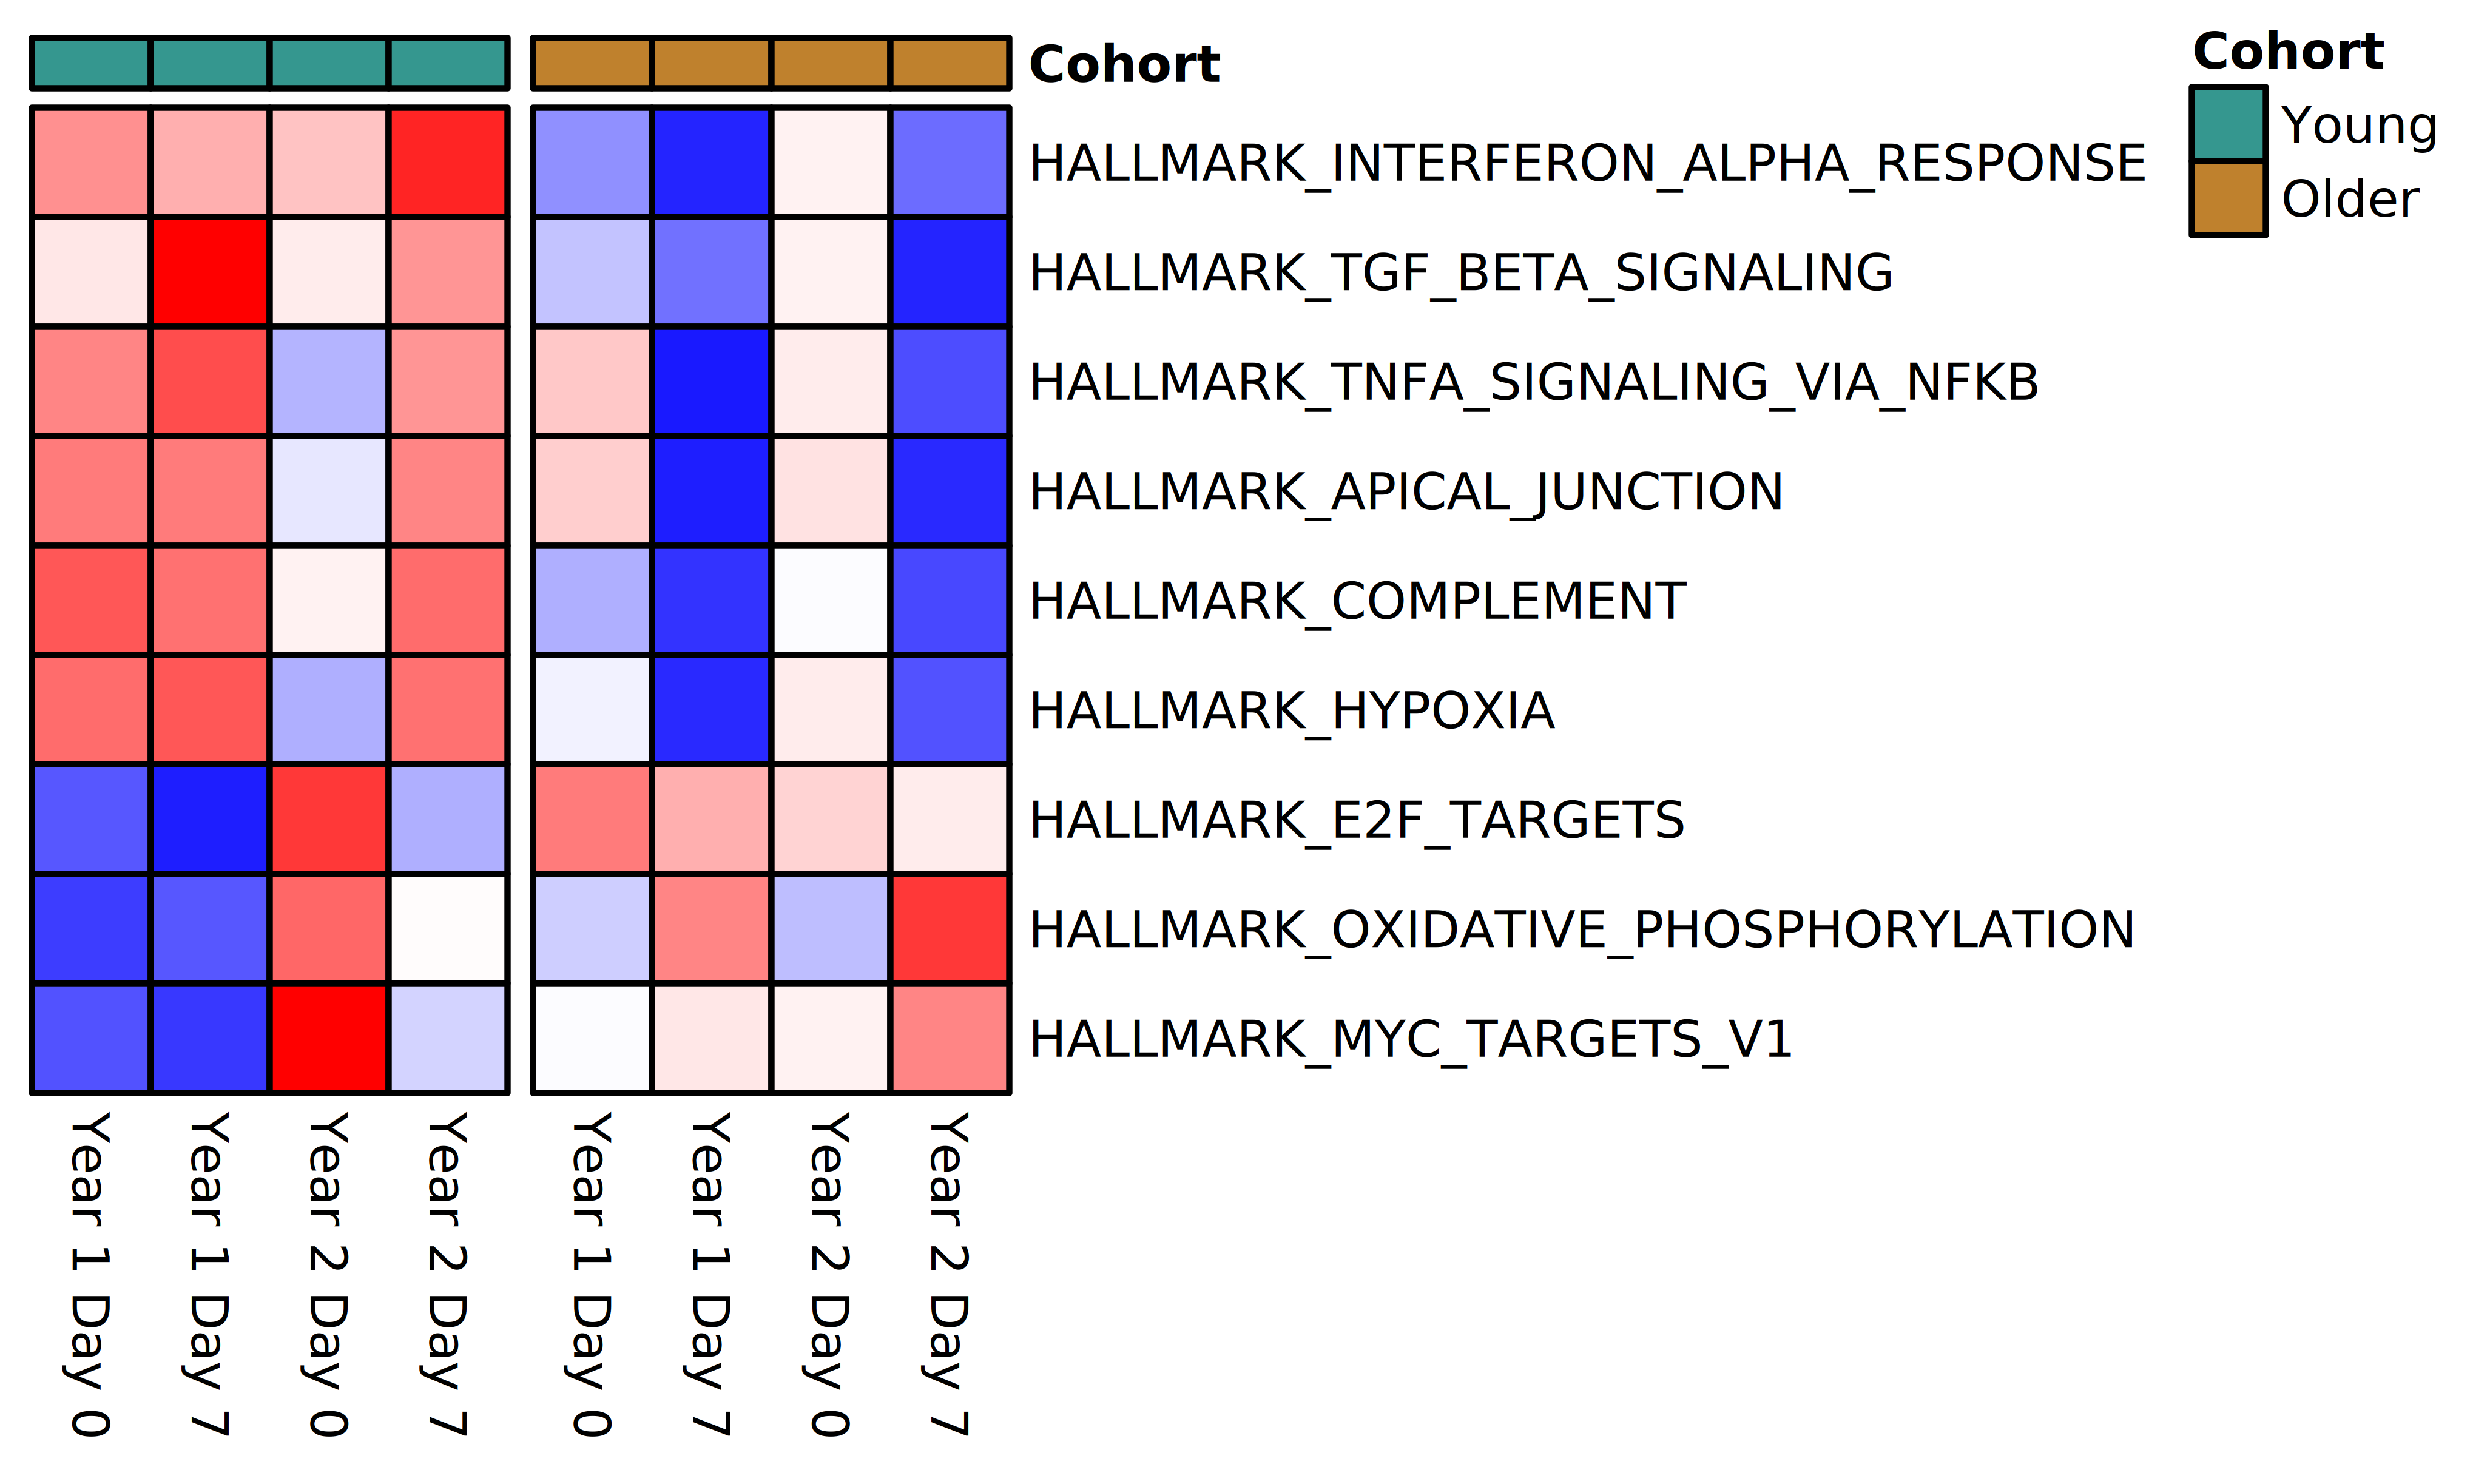

In [46]:
plot_width = 55/25.3 *2.5
plot_height = 33/25.3 *2.5
plot_res = 300 *2.5

options(repr.plot.width=plot_width, repr.plot.height=plot_height, repr.plot.res=plot_res)
# Use the revalue function from the plyr package
annotation_df$Cohort <- plyr::revalue(annotation_df$Cohort, c("BR1"="Young", "BR2"="Older"))

#  Set custom colors for the cohorts
annotation_colors <- list(Cohort = c(Young = "#35978F", Older = "#BF812D"))

# Generate the heatmap with pheatmap
plot <- pheatmap(x_subset, 
         scale = "row", 
         cluster_cols = FALSE, 
         cluster_rows = FALSE, 
         fontsize = 8,
         color = colorPalette, 
         gaps_col = c(4),
         clustering_method = "ward.D", 
         annotation_col = annotation_df, 
         annotation_colors = annotation_colors, 
         labels_col = column_labels, 
         border_color = "black",
         legend = FALSE,
         annotation_legend = TRUE)

In [ ]:
ggsave(filename = "ExtFig4_Outputs/supp_fig_4C.png", 
       plot = plot, 
       width = plot_width, 
       height = plot_height, 
       dpi = plot_res)

## Supp Fig 4D

In [22]:
# Core memory B cells
combinedDf <- as.data.frame(all_combined_dfs$`Core memory B cell`)

# Do pathway scores (SLEA) for each pathway in all cell subsets
# Initialize an empty list to store the sleaDF1 dataframes
sleaDF1_list <- list()

# Iterate over each dataframe in new_data_frames1
for (i in 1:length(new_data_frames2)) {
  # Get the current expression set from new_data_frames1
  expressionSet <- new_data_frames2[[i]]
  
  # Apply the SLEA function to each gene set in combinedDf
  sleaLS1 <- lapply(1:length(combinedDf), function(l) {
    geneSet <- combinedDf[[l]] %>% strsplit(",") %>% unlist(.)
    sDF <- doSLEA(expressionSet = expressionSet, geneSet = geneSet)
    names(sDF) <- names(combinedDf[l])
    return(sDF)
  })
  
  # Combine the results into a single dataframe
  sleaDF1 <- do.call(cbind, sleaLS1)
  sleaDF1 <- sleaDF1 %>% t() %>% as.data.frame()
  
  # Store the resulting dataframe in the list
  sleaDF1_list[[i]] <- sleaDF1
}

# name the list
names(sleaDF1_list) <- names(new_data_frames1)

# Do pathway scores (SLEA) for each pathway in all cell subsets

# Initialize an empty list to store the sleaDF1 dataframes
sleaDF1_list <- list()

# Iterate over each dataframe in new_data_frames1
for (i in 1:length(new_data_frames2)) {
  # Get the current expression set from new_data_frames1
  expressionSet <- new_data_frames2[[i]]
  
  # Apply the SLEA function to each gene set in combinedDf
  sleaLS1 <- lapply(1:length(combinedDf), function(l) {
    geneSet <- combinedDf[[l]] %>% strsplit(",") %>% unlist(.)
    sDF <- doSLEA(expressionSet = expressionSet, geneSet = geneSet)
    names(sDF) <- names(combinedDf[l])
    return(sDF)
  })
  
  # Combine the results into a single dataframe
  sleaDF1 <- do.call(cbind, sleaLS1)
  sleaDF1 <- sleaDF1 %>% t() %>% as.data.frame()
  
  # Store the resulting dataframe in the list
  sleaDF1_list[[i]] <- sleaDF1
}

# name the list
names(sleaDF1_list) <- names(new_data_frames1)

# average the SLEA scores for samples in the same cohort and the same timepoint for each subset
# Initialize an empty list to store the new dataframes
averaged_sleaDF1_list <- list()

# Iterate over each dataframe in sleaDF1_list
for (i in 1:length(sleaDF1_list)) {
  # Get the current sleaDF1 dataframe
  sleaDF1 <- sleaDF1_list[[i]]
  
  # Match the columns of sleaDF1 to the metadata
  matched_metadata <- meta_data_subset[match(colnames(sleaDF1), rownames(meta_data_subset)), ]
  
  # Combine sleaDF1 and matched_metadata
  combined_df <- cbind(matched_metadata, t(sleaDF1))

  # Identify columns to keep: cohort.cohortGuid, sample.visitName, and all columns after Strains_concat
  columns_to_keep <- c("cohort.cohortGuid", "sample.visitName", names(combined_df)[(which(names(combined_df) == "Strains_concat") + 1):ncol(combined_df)])

  # Select the identified columns
  selected_columns <- combined_df %>%
    select(all_of(columns_to_keep))
  
  # Group by 'cohort.cohortGuid' and 'sample.visitName' and calculate the mean for all other columns
  averaged_df <- selected_columns %>%
    group_by(cohort.cohortGuid, sample.visitName) %>%
    summarize_all(list(~mean(., na.rm = TRUE)))
  
  # Store the averaged dataframe in the list
  averaged_sleaDF1_list[[i]] <- averaged_df
}

# name the list
names(averaged_sleaDF1_list) <- names(sleaDF1_list)

options(repr.plot.width=10, repr.plot.height=4)

colorPalette <- c("blue", "white", "red")
colorPalette <- colorRampPalette(colors = colorPalette)(100)

x <- as.data.frame(averaged_sleaDF1_list$`Core memory B cell`)
rownames(x) <- paste(x[, 1], x[, 2], sep = "_")
x_subset <- as.data.frame(t(x[, 3:ncol(x), drop = FALSE]))
colnames(x_subset) <- rownames(x)

The following `from` values were not present in `x`: BR1, BR2



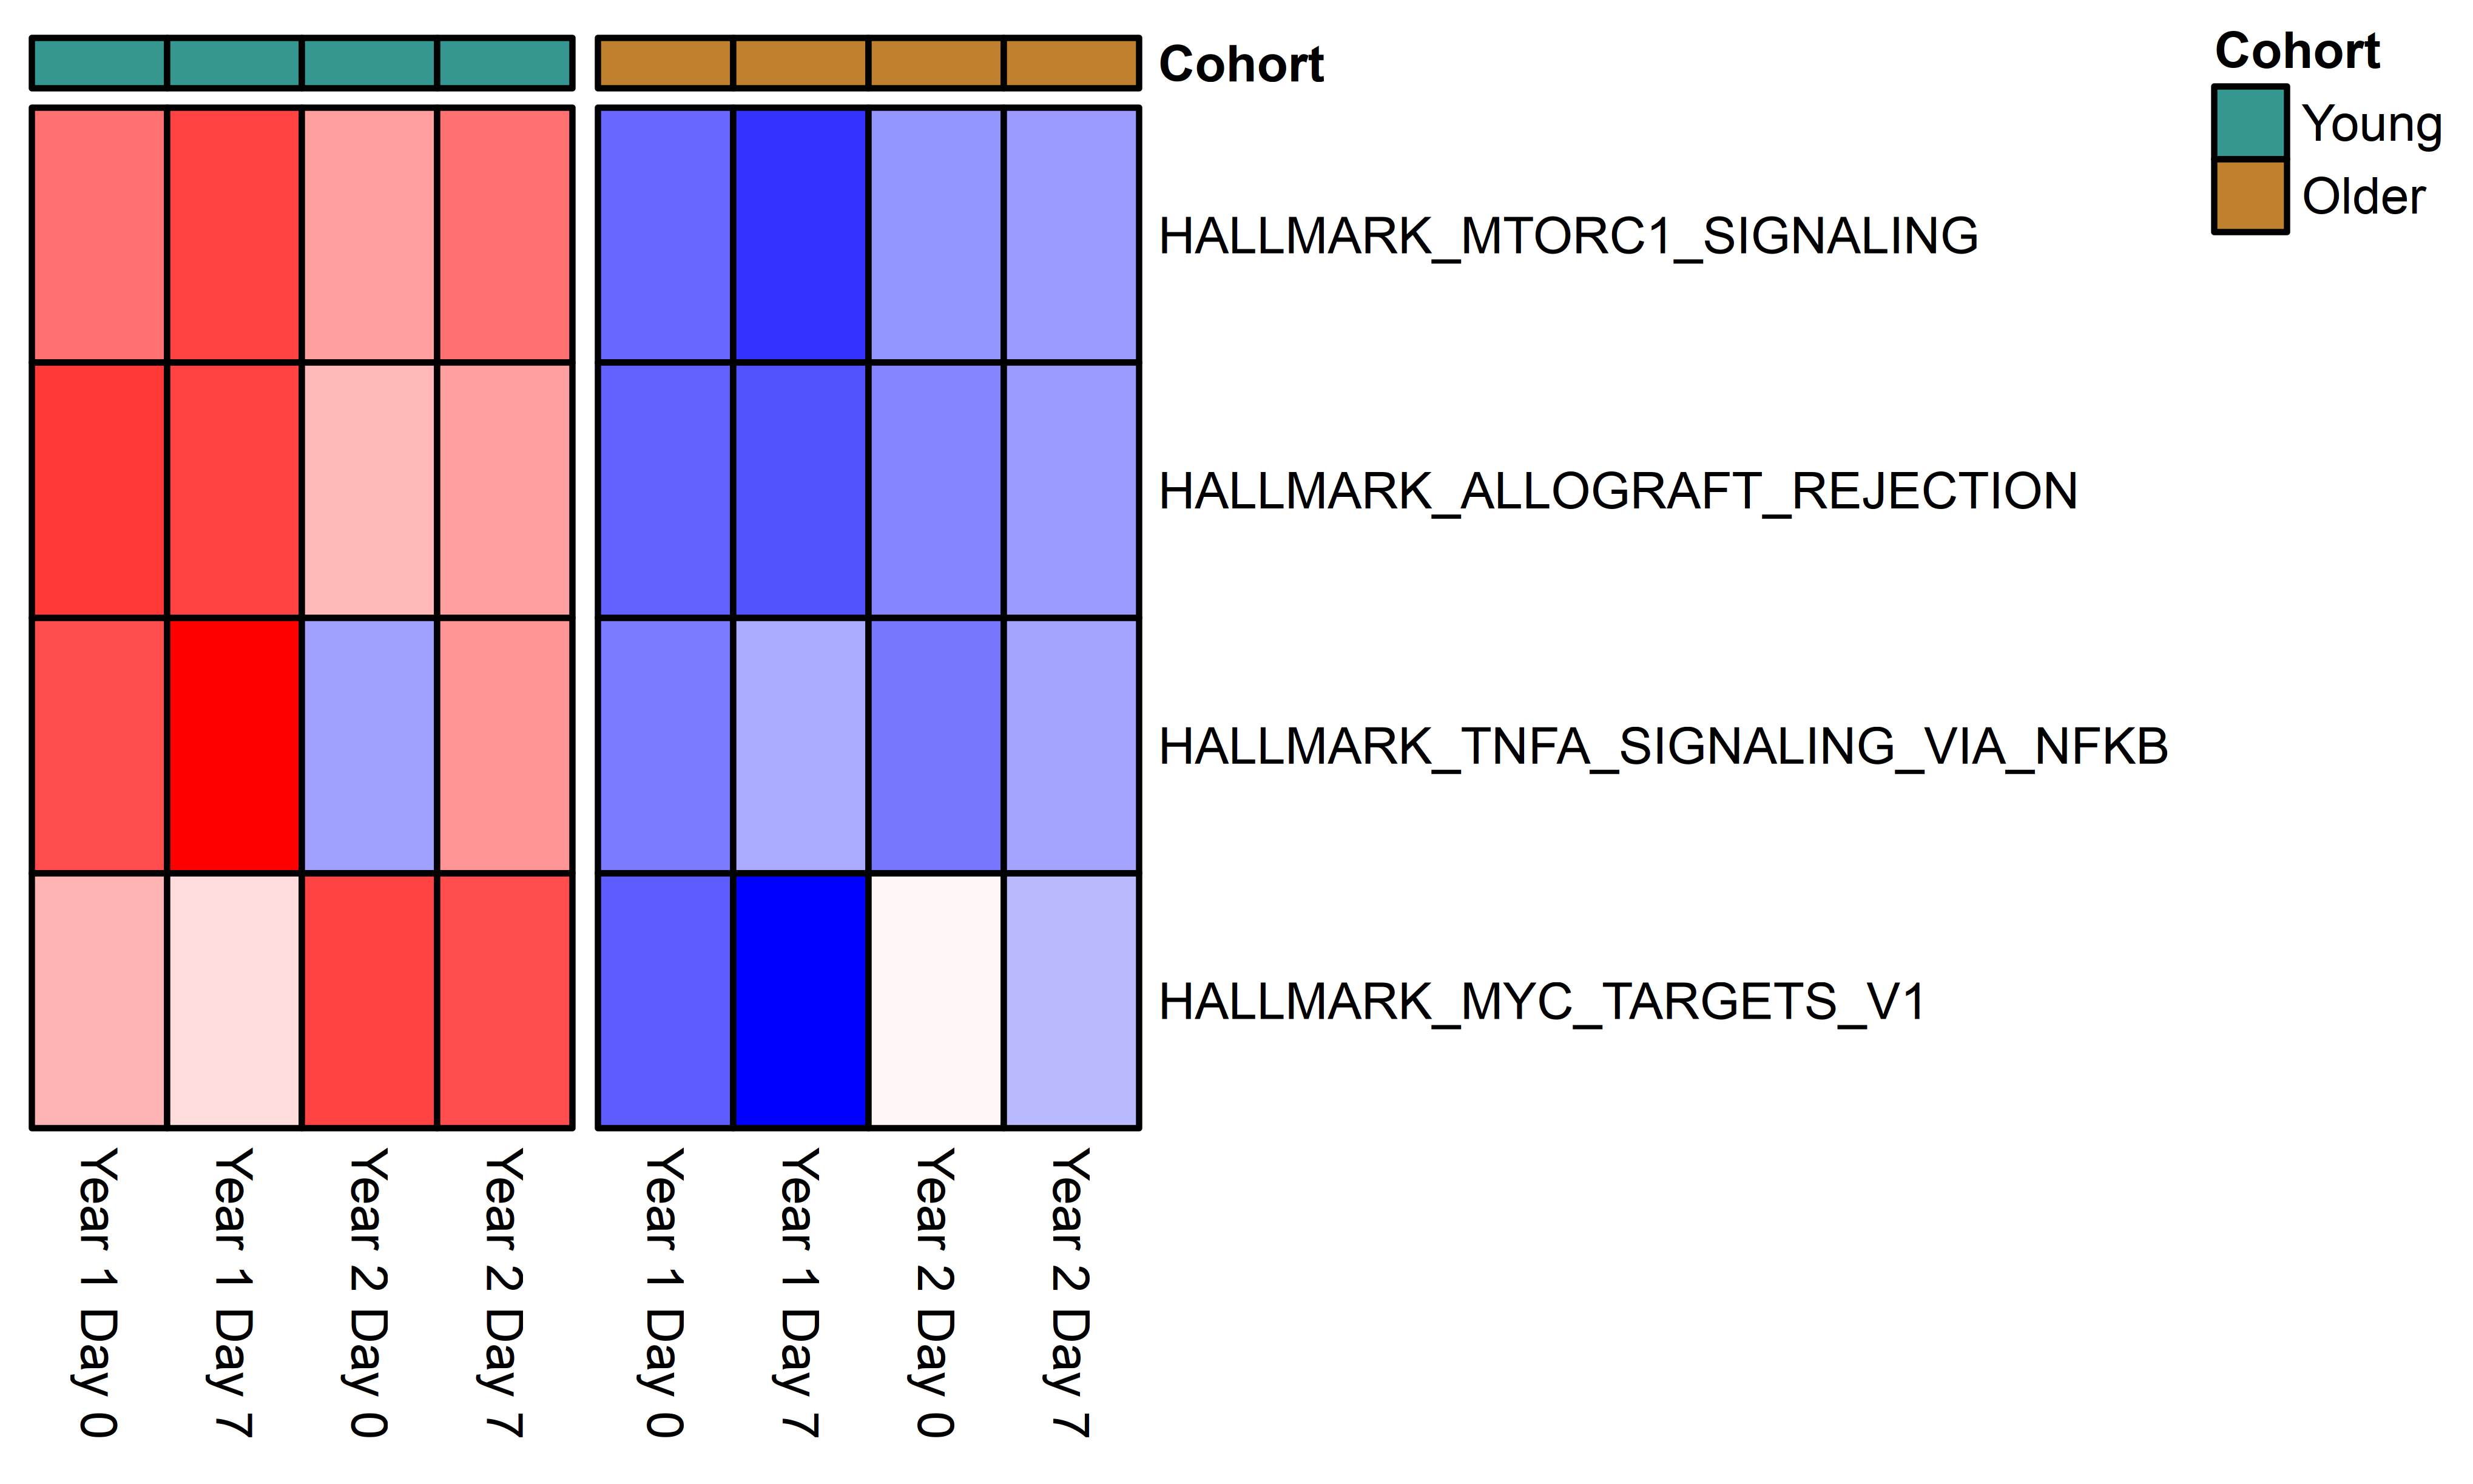

In [23]:
plot_width = 55/25.3 *2.5
plot_height = 33/25.3 *2.5
plot_res = 300 *2.5

options(repr.plot.width=plot_width, repr.plot.height=plot_height, repr.plot.res=plot_res)
# Use the revalue function from the plyr package
annotation_df$Cohort <- plyr::revalue(annotation_df$Cohort, c("BR1"="Young", "BR2"="Older"))

#  Set custom colors for the cohorts
annotation_colors <- list(Cohort = c(Young = "#35978F", Older = "#BF812D"))

# Generate the heatmap with pheatmap
plot <- pheatmap(x_subset, 
         scale = "row", 
         cluster_cols = FALSE, 
         cluster_rows = FALSE, 
         fontsize = 8,
         color = colorPalette, 
         gaps_col = c(4),
         clustering_method = "ward.D", 
         annotation_col = annotation_df, 
         annotation_colors = annotation_colors, 
         labels_col = column_labels, 
         border_color = "black",
         legend = FALSE,
         annotation_legend = TRUE)

In [25]:
ggsave(filename = "ExtFig4_Outputs/supp_fig_4D.png", 
       plot = plot, 
       width = plot_width, 
       height = plot_height, 
       dpi = plot_res)

## Supp Fig E

In [26]:
# CD27+ effector memory B cells
combinedDf <- as.data.frame(all_combined_dfs$`CD27+ effector B cell`)

# Do pathway scores (SLEA) for each pathway in all cell subsets
# Initialize an empty list to store the sleaDF1 dataframes
sleaDF1_list <- list()

# Iterate over each dataframe in new_data_frames1
for (i in 1:length(new_data_frames2)) {
  # Get the current expression set from new_data_frames1
  expressionSet <- new_data_frames2[[i]]
  
  # Apply the SLEA function to each gene set in combinedDf
  sleaLS1 <- lapply(1:length(combinedDf), function(l) {
    geneSet <- combinedDf[[l]] %>% strsplit(",") %>% unlist(.)
    sDF <- doSLEA(expressionSet = expressionSet, geneSet = geneSet)
    names(sDF) <- names(combinedDf[l])
    return(sDF)
  })
  
  # Combine the results into a single dataframe
  sleaDF1 <- do.call(cbind, sleaLS1)
  sleaDF1 <- sleaDF1 %>% t() %>% as.data.frame()
  
  # Store the resulting dataframe in the list
  sleaDF1_list[[i]] <- sleaDF1
}

# name the list
names(sleaDF1_list) <- names(new_data_frames1)

# Do pathway scores (SLEA) for each pathway in all cell subsets
# Initialize an empty list to store the sleaDF1 dataframes
sleaDF1_list <- list()

# Iterate over each dataframe in new_data_frames1
for (i in 1:length(new_data_frames2)) {
  # Get the current expression set from new_data_frames1
  expressionSet <- new_data_frames2[[i]]
  
  # Apply the SLEA function to each gene set in combinedDf
  sleaLS1 <- lapply(1:length(combinedDf), function(l) {
    geneSet <- combinedDf[[l]] %>% strsplit(",") %>% unlist(.)
    sDF <- doSLEA(expressionSet = expressionSet, geneSet = geneSet)
    names(sDF) <- names(combinedDf[l])
    return(sDF)
  })
  
  # Combine the results into a single dataframe
  sleaDF1 <- do.call(cbind, sleaLS1)
  sleaDF1 <- sleaDF1 %>% t() %>% as.data.frame()
  
  # Store the resulting dataframe in the list
  sleaDF1_list[[i]] <- sleaDF1
}

# name the list
names(sleaDF1_list) <- names(new_data_frames1)

# average the SLEA scores for samples in the same cohort and the same timepoint for each subset
# Initialize an empty list to store the new dataframes
averaged_sleaDF1_list <- list()

# Iterate over each dataframe in sleaDF1_list
for (i in 1:length(sleaDF1_list)) {
  # Get the current sleaDF1 dataframe
  sleaDF1 <- sleaDF1_list[[i]]
  
  # Match the columns of sleaDF1 to the metadata
  matched_metadata <- meta_data_subset[match(colnames(sleaDF1), rownames(meta_data_subset)), ]
  
  # Combine sleaDF1 and matched_metadata
  combined_df <- cbind(matched_metadata, t(sleaDF1))

  # Identify columns to keep: cohort.cohortGuid, sample.visitName, and all columns after Strains_concat
  columns_to_keep <- c("cohort.cohortGuid", "sample.visitName", names(combined_df)[(which(names(combined_df) == "Strains_concat") + 1):ncol(combined_df)])

  # Select the identified columns
  selected_columns <- combined_df %>%
    select(all_of(columns_to_keep))
  
  # Group by 'cohort.cohortGuid' and 'sample.visitName' and calculate the mean for all other columns
  averaged_df <- selected_columns %>%
    group_by(cohort.cohortGuid, sample.visitName) %>%
    summarize_all(list(~mean(., na.rm = TRUE)))
  
  # Store the averaged dataframe in the list
  averaged_sleaDF1_list[[i]] <- averaged_df
}

# name the list
names(averaged_sleaDF1_list) <- names(sleaDF1_list)

options(repr.plot.width=10, repr.plot.height=4)

colorPalette <- c("blue", "white", "red")
colorPalette <- colorRampPalette(colors = colorPalette)(100)

x <- as.data.frame(averaged_sleaDF1_list$`CD27+ effector B cell`)
rownames(x) <- paste(x[, 1], x[, 2], sep = "_")
x_subset <- as.data.frame(t(x[, 3:ncol(x), drop = FALSE]))
colnames(x_subset) <- rownames(x)

The following `from` values were not present in `x`: BR1, BR2



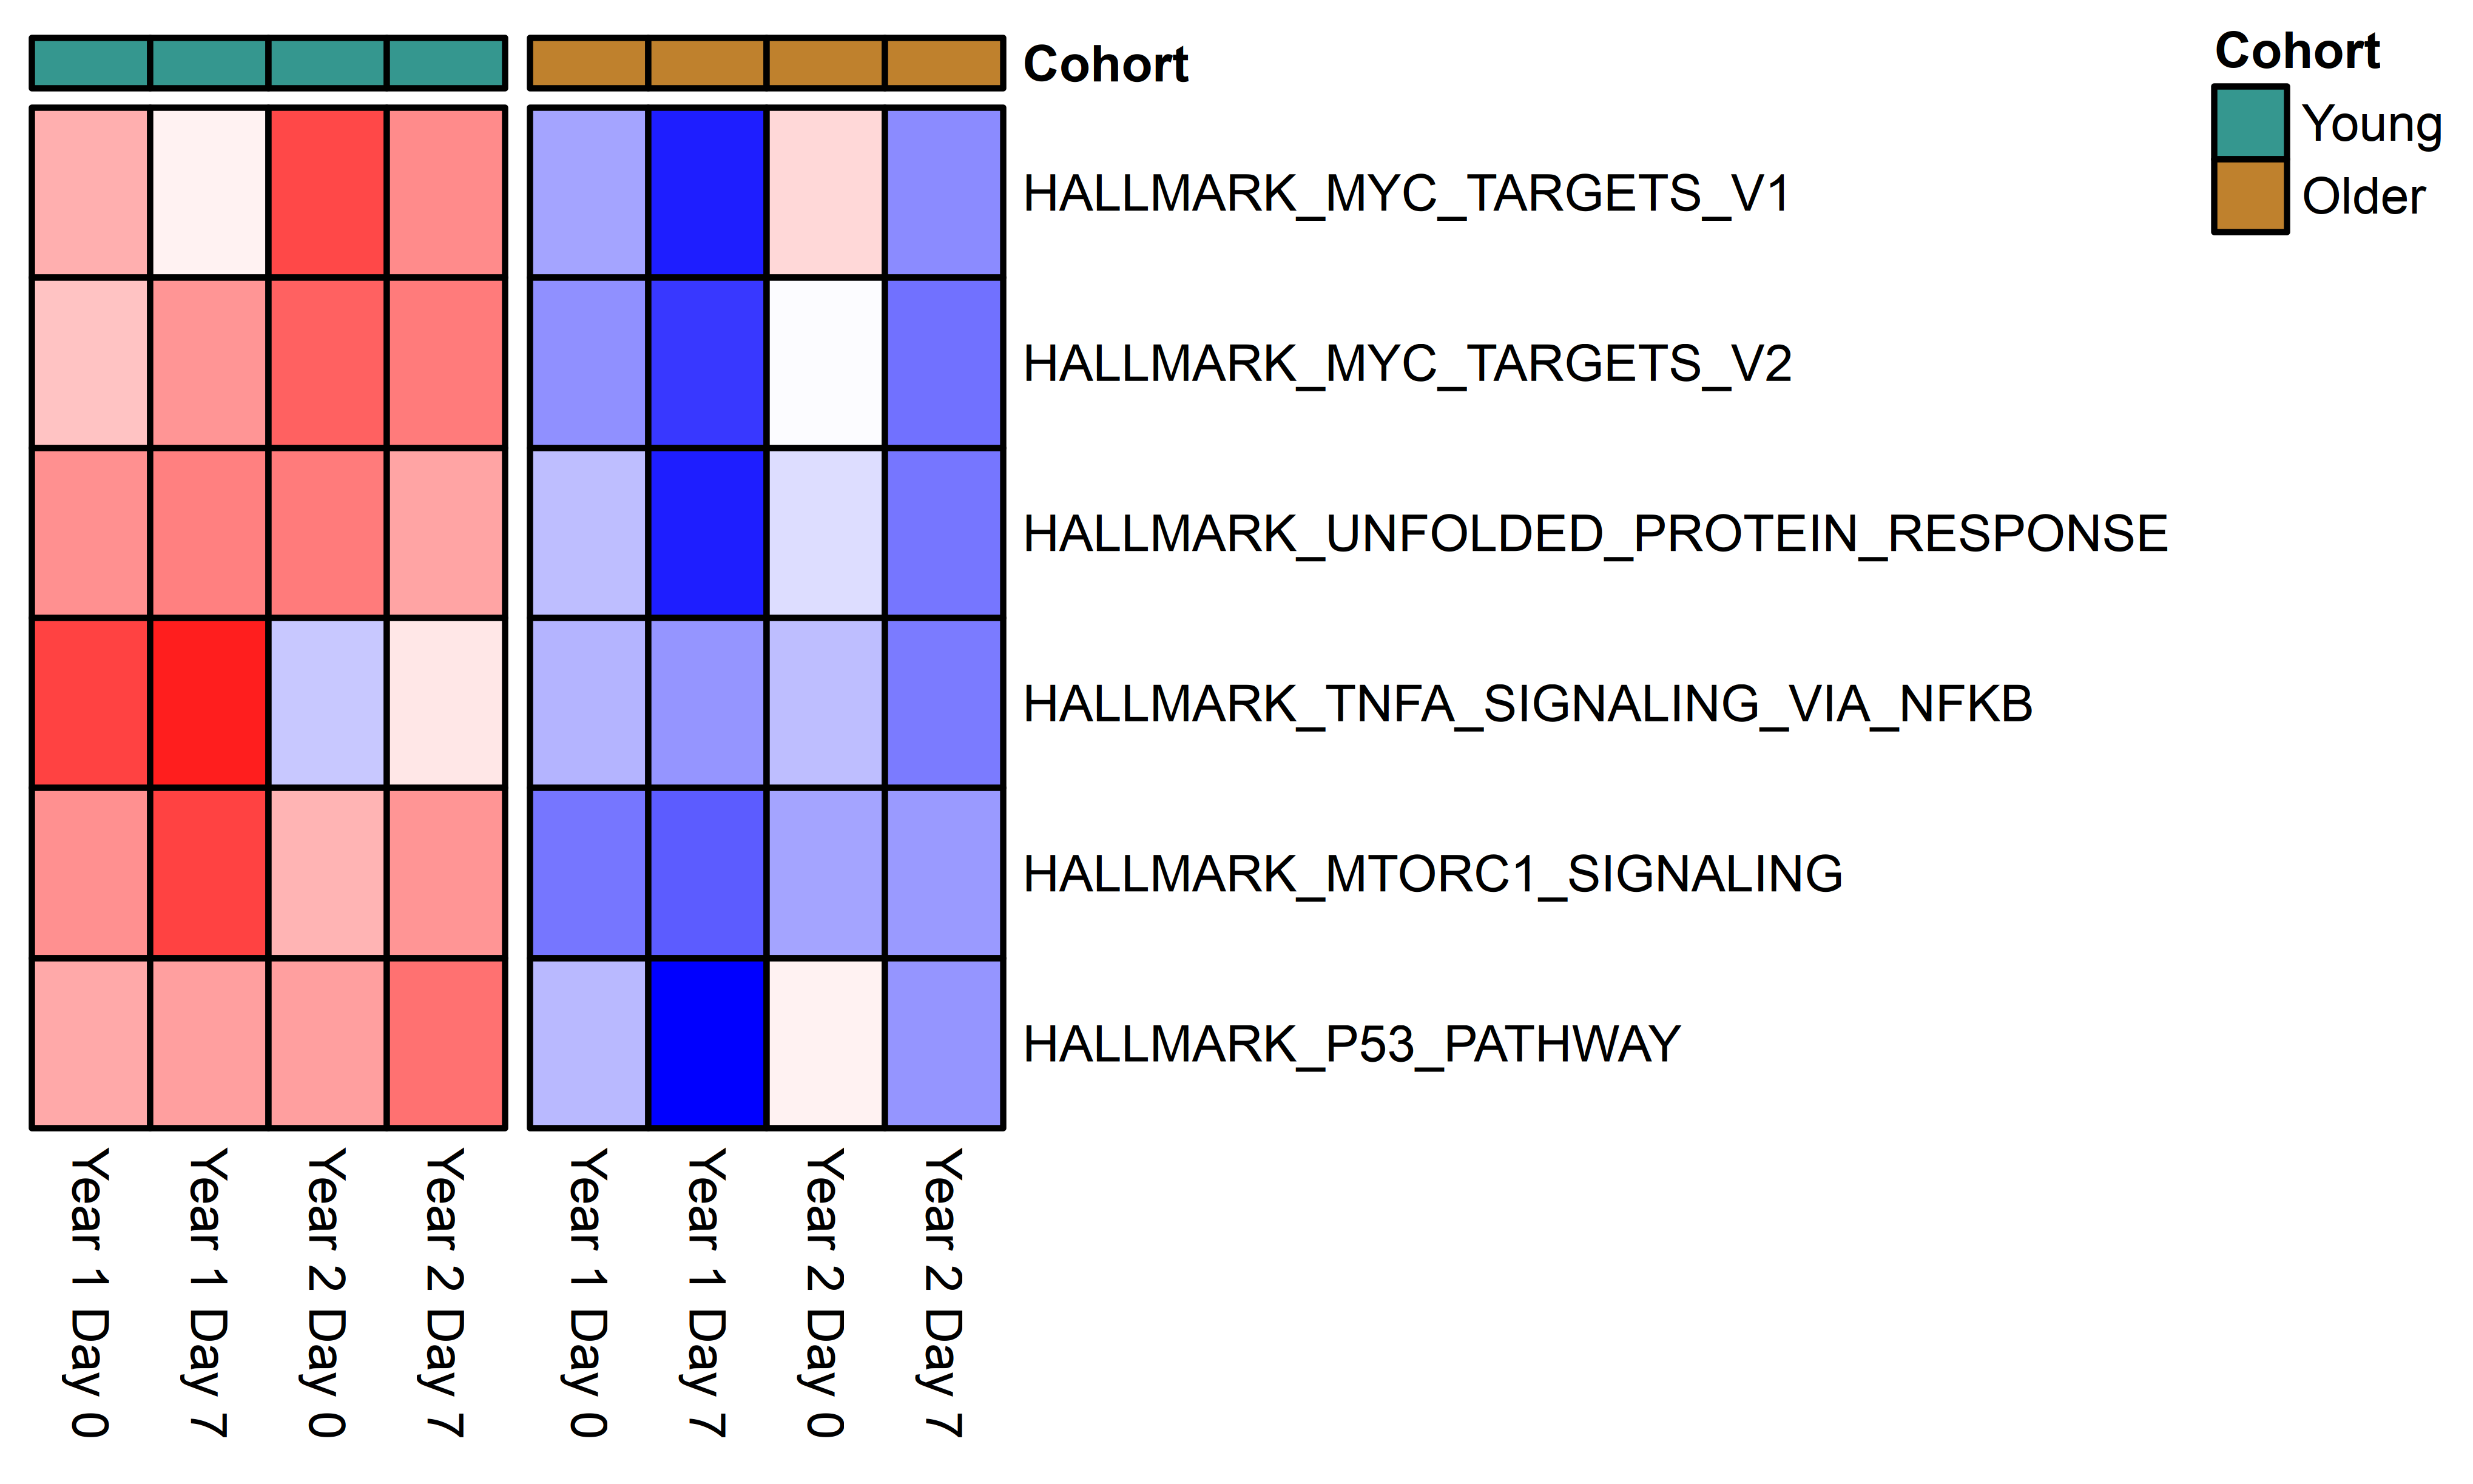

In [27]:
plot_width = 55/25.3 *2.5
plot_height = 33/25.3 *2.5
plot_res = 300 *2.5

options(repr.plot.width=plot_width, repr.plot.height=plot_height, repr.plot.res=plot_res)
# Use the revalue function from the plyr package
annotation_df$Cohort <- plyr::revalue(annotation_df$Cohort, c("BR1"="Young", "BR2"="Older"))

#  Set custom colors for the cohorts
annotation_colors <- list(Cohort = c(Young = "#35978F", Older = "#BF812D"))

# Generate the heatmap with pheatmap
plot <- pheatmap(x_subset, 
         scale = "row", 
         cluster_cols = FALSE, 
         cluster_rows = FALSE, 
         fontsize = 8,
         color = colorPalette, 
         gaps_col = c(4),
         clustering_method = "ward.D", 
         annotation_col = annotation_df, 
         annotation_colors = annotation_colors, 
         labels_col = column_labels, 
         border_color = "black",
         legend = FALSE,
         annotation_legend = TRUE)

In [28]:
ggsave(filename = "ExtFig4_Outputs/supp_fig_4E.png", 
       plot = plot, 
       width = plot_width, 
       height = plot_height, 
       dpi = plot_res)